In [6]:
!pip install pybaseball

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from pybaseball import statcast
from pybaseball import playerid_lookup, statcast_pitcher
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
start_date = '2023-04-01'
end_date = '2023-05-10'
data = statcast(start_dt=start_date, end_dt=end_date)
selected_columns = [
    'pitch_type', 'player_name', 'stand', 'p_throws', 
    'balls', 'strikes', 'game_year', 'outs_when_up', 'inning', 
    'pitch_number', 'bat_score', 
    'fld_score', 'if_fielding_alignment', 'of_fielding_alignment'
]
filtered_data = data[selected_columns]
pitcher_data = filtered_data[filtered_data['player_name'] == 'Manaea, Sean']
pitcher_data

This is a large query, it may take a moment to complete


  0%|          | 0/40 [00:00<?, ?it/s]/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  2%|▎         | 1/40 [00:00<00:31,  1.23it/s]/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  5%|▌         | 2/40 [00:01<00:17,  2.16it/s]/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is de

,pitch_type,player_name,stand,p_throws,balls,strikes,game_year,outs_when_up,inning,pitch_number,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
483,SI,"Manaea, Sean",R,L,1,1,2023,2,3,3,6,0,Standard,Standard
507,CH,"Manaea, Sean",R,L,0,1,2023,2,3,2,6,0,Standard,Standard
513,FF,"Manaea, Sean",R,L,0,0,2023,2,3,1,6,0,Standard,Standard
542,CH,"Manaea, Sean",R,L,1,0,2023,2,3,2,4,0,Standard,Standard
569,CH,"Manaea, Sean",R,L,0,0,2023,2,3,1,4,0,Standard,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,FF,"Manaea, Sean",L,L,3,1,2023,0,7,5,0,7,Strategic,Standard
4108,FF,"Manaea, Sean",L,L,3,0,2023,0,7,4,0,7,Standard,Standard
4303,FF,"Manaea, Sean",L,L,2,0,2023,0,7,3,0,7,Standard,Standard
4454,FF,"Manaea, Sean",L,L,1,0,2023,0,7,2,0,7,Standard,Standard


In [9]:
pitcher_data = pitcher_data.copy()

In [10]:
pitcher_data.shape

(532, 14)

In [11]:
pitcher_data['pitch_type'].value_counts()

pitch_type
FF    229
SL    159
CH    138
SI      6
Name: count, dtype: int64

In [12]:
pitcher_data['if_fielding_alignment'].value_counts()

if_fielding_alignment
Standard         377
Infield shade     51
Strategic         33
Name: count, dtype: int64

In [13]:
pitcher_data['of_fielding_alignment'].value_counts()

of_fielding_alignment
Standard     419
Strategic     42
Name: count, dtype: int64

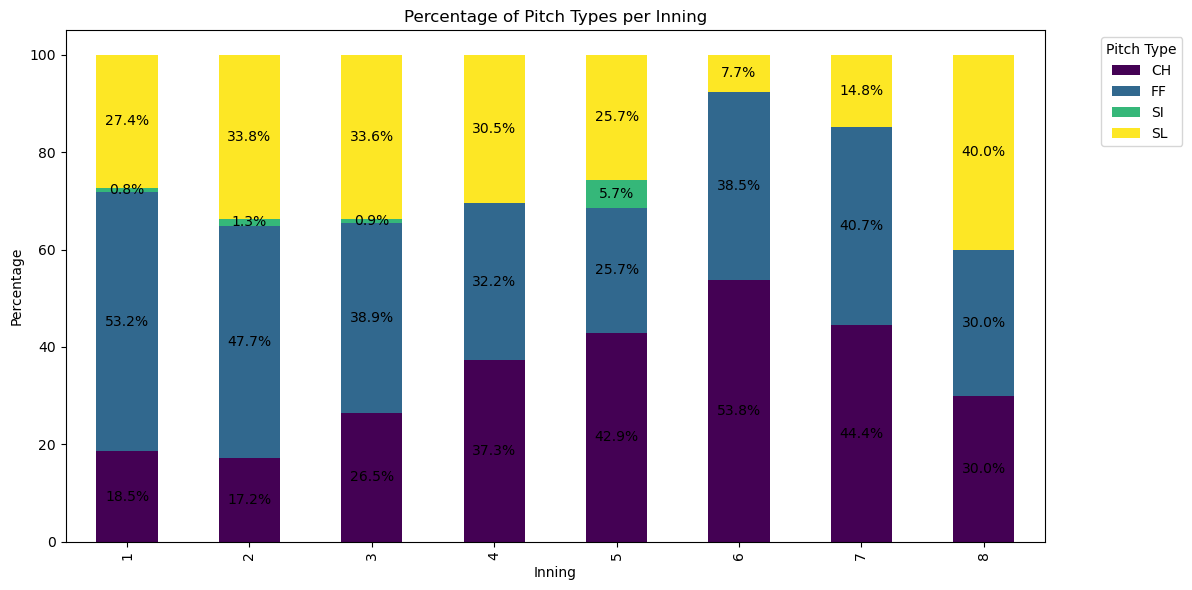

In [14]:

pitch_counts = pitcher_data.groupby(['inning', 'pitch_type']).size().unstack(fill_value=0)

pitch_percentage = pitch_counts.div(pitch_counts.sum(axis=1), axis=0) * 100

ax = pitch_percentage.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

plt.title('Percentage of Pitch Types per Inning')
plt.xlabel('Inning')
plt.ylabel('Percentage')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(
        container, 
        labels=[f'{val:.1f}%' if val > 0 else '' for val in container.datavalues], 
        label_type='center'
    )

plt.tight_layout()
plt.show()


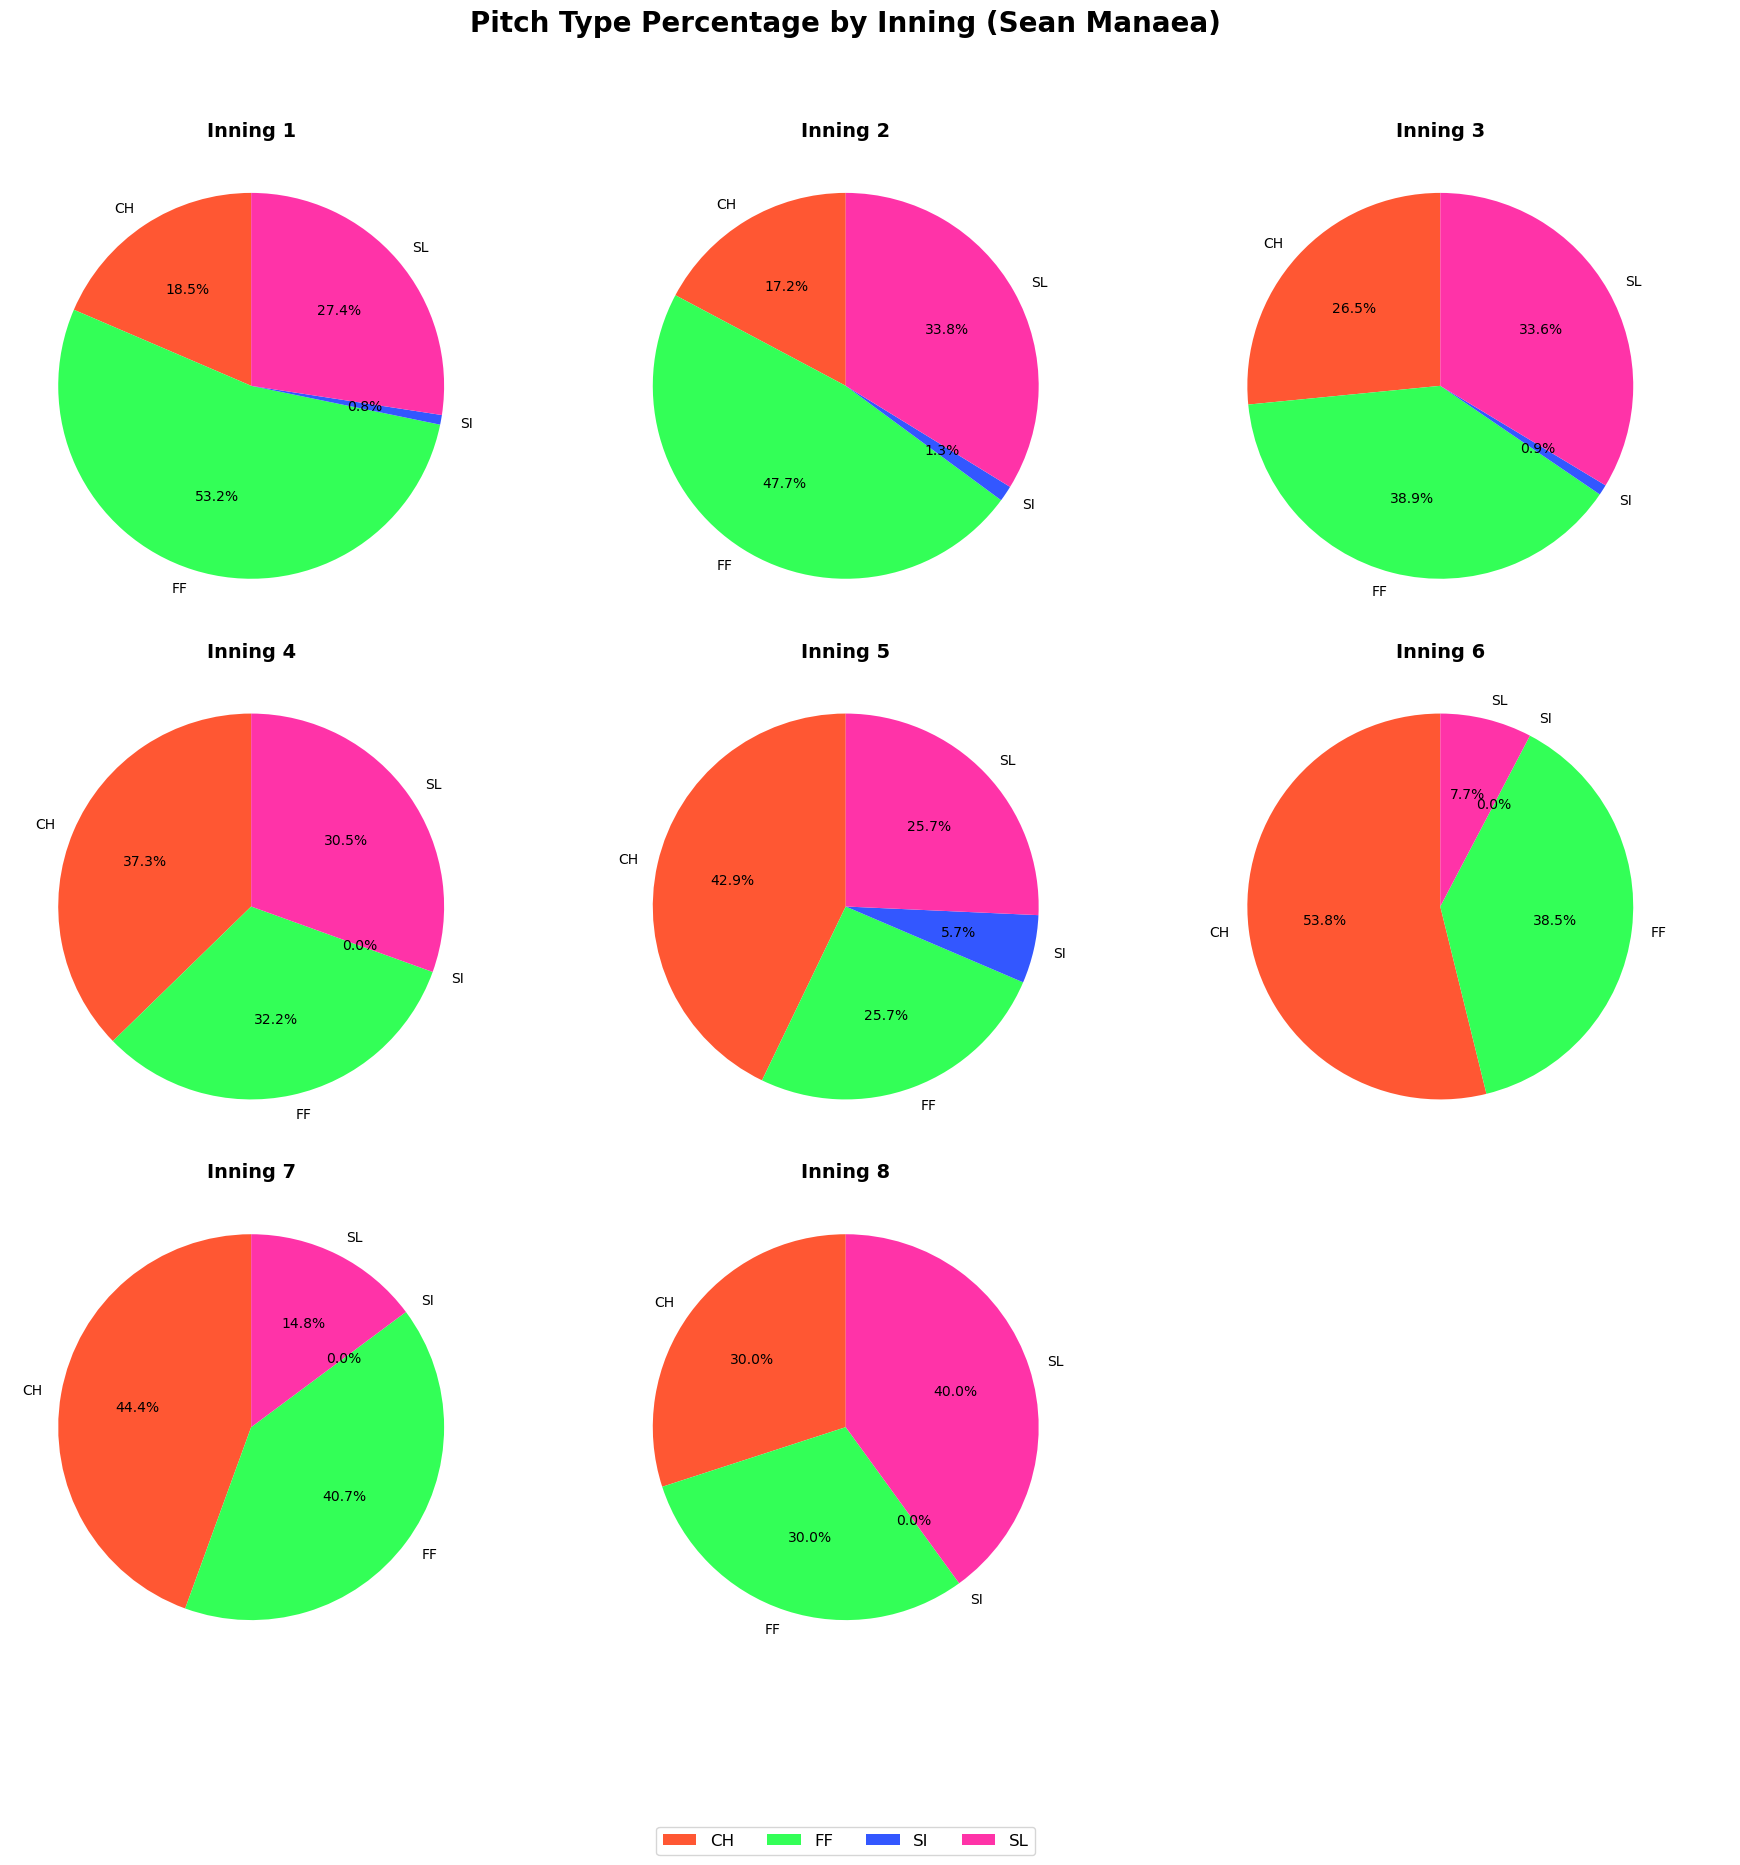

ModuleNotFoundError: No module named 'ace_tools'

In [15]:

pitch_counts_by_inning = pitcher_data.groupby(['inning', 'pitch_type']).size().unstack(fill_value=0)

colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A8', '#FF9633', '#33FFF3', '#A833FF', '#FFFF33', '#33FF9E']

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, ax in enumerate(axes.flatten(), start=1):
    if i in pitch_counts_by_inning.index: 
        pitch_counts = pitch_counts_by_inning.loc[i]
        wedges, texts, autotexts = ax.pie(
            pitch_counts, 
            labels=pitch_counts.index, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=colors[:len(pitch_counts)]
        )
        for text in texts:
            text.set_fontsize(10)
        for autotext in autotexts:
            autotext.set_fontsize(10)
        ax.set_title(f'Inning {i}', fontsize=14, fontweight='bold')
    else:
        ax.axis('off')  

fig.suptitle('Pitch Type Percentage by Inning (Sean Manaea)', fontsize=20, fontweight='bold')

fig.legend(
    pitch_counts_by_inning.columns, 
    loc='lower center', 
    ncol=5, 
    bbox_to_anchor=(0.5, -0.05), 
    fontsize=12
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()

summary_table = pitch_counts_by_inning.T

import ace_tools as tools; tools.display_dataframe_to_user(name="Pitch Type Counts by Inning")



In [16]:
le_stand = LabelEncoder()
le_p_throws = LabelEncoder()
le_if_align = LabelEncoder()
le_of_align = LabelEncoder()
pitcher_data['stand'] = le_stand.fit_transform(pitcher_data['stand'])
pitcher_data['p_throws'] = le_p_throws.fit_transform(pitcher_data['p_throws'])
pitcher_data['if_fielding_alignment'] = le_if_align.fit_transform(pitcher_data['if_fielding_alignment'])
pitcher_data['of_fielding_alignment'] = le_of_align.fit_transform(pitcher_data['of_fielding_alignment'])

In [17]:
X = pitcher_data.drop(['pitch_type', 'player_name'], axis=1)
y = pitcher_data['pitch_type']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
def predict_pitch_type(outs_when_up, inning, balls, strikes, Pitch_number, Bat_score, Fld_score):
    current_game = pd.DataFrame([{
        'stand': le_stand.transform(['R'])[0],
        'p_throws': le_p_throws.transform(['L'])[0],
        'balls': balls,
        'strikes': strikes,
        'game_year': 2023,
        'outs_when_up': outs_when_up,
        'inning': inning,
        'pitch_number': Pitch_number,
        'bat_score': Bat_score,
        'fld_score': Fld_score,
        'if_fielding_alignment': le_if_align.transform(['Standard'])[0],
        'of_fielding_alignment': le_of_align.transform(['Standard'])[0]
    }])
    
    probabilities = model.predict_proba(current_game)[0]

    pitch_type_probs = dict(zip(model.classes_, probabilities))
    
    return pitch_type_probs

outs_when_up = 2
inning = 8
balls = 2
strikes = 2
Pitch_number = 4
Bat_score = 9
Fld_score = 7

In [21]:
pitch_type_probs = predict_pitch_type(outs_when_up, inning, balls, strikes, Pitch_number, Bat_score, Fld_score)

In [25]:
pitch_type_probs_df = pd.DataFrame(
        pitch_type_probs.items(), columns=['Pitch Type', 'Probability'])
pitch_type_probs_df

,Pitch Type,Probability
0,CH,0.57
1,FF,0.03
2,SI,0.00
3,SL,0.40


In [26]:
pitch_type_probs_df = pd.DataFrame(
        pitch_type_probs.items(), columns=['Pitch Type', 'Probability']
    ).sort_values(by='Probability', ascending=False).reset_index(drop=True)
pitch_type_probs_df

,Pitch Type,Probability
0,CH,0.57
1,SL,0.40
2,FF,0.03
3,SI,0.00


In [16]:
start_date = '2023-04-01'
end_date = '2023-05-10'
data_pitch_speed = statcast(start_dt=start_date, end_dt=end_date)
selected_columns = [
    'pitch_type', 'player_name', 'stand', 'p_throws', 
    'balls', 'strikes', 'game_year', 'outs_when_up', 'inning', 
    'pitch_number', 'bat_score', 'effective_speed',
    'fld_score', 'if_fielding_alignment', 'of_fielding_alignment'
]
filtered_data = data_pitch_speed[selected_columns]
effective_speed_data = filtered_data[filtered_data['player_name'] == 'Manaea, Sean']
effective_speed_data

This is a large query, it may take a moment to complete


  0%|          | 0/40 [00:00<?, ?it/s]/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  2%|▎         | 1/40 [00:00<00:25,  1.55it/s]/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. U

,pitch_type,player_name,stand,p_throws,balls,strikes,game_year,outs_when_up,inning,pitch_number,bat_score,effective_speed,fld_score,if_fielding_alignment,of_fielding_alignment
474,SI,"Manaea, Sean",R,L,1,1,2023,2,3,3,6,92.7,0,Standard,Standard
508,CH,"Manaea, Sean",R,L,0,1,2023,2,3,2,6,86.8,0,Standard,Standard
520,FF,"Manaea, Sean",R,L,0,0,2023,2,3,1,6,91.9,0,Standard,Standard
561,CH,"Manaea, Sean",R,L,1,0,2023,2,3,2,4,86.1,0,Standard,Standard
570,CH,"Manaea, Sean",R,L,0,0,2023,2,3,1,4,87.8,0,Standard,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029,FF,"Manaea, Sean",L,L,3,1,2023,0,7,5,0,97.2,7,Strategic,Standard
4170,FF,"Manaea, Sean",L,L,3,0,2023,0,7,4,0,96.9,7,Standard,Standard
4283,FF,"Manaea, Sean",L,L,2,0,2023,0,7,3,0,98.3,7,Standard,Standard
4465,FF,"Manaea, Sean",L,L,1,0,2023,0,7,2,0,97.3,7,Standard,Standard


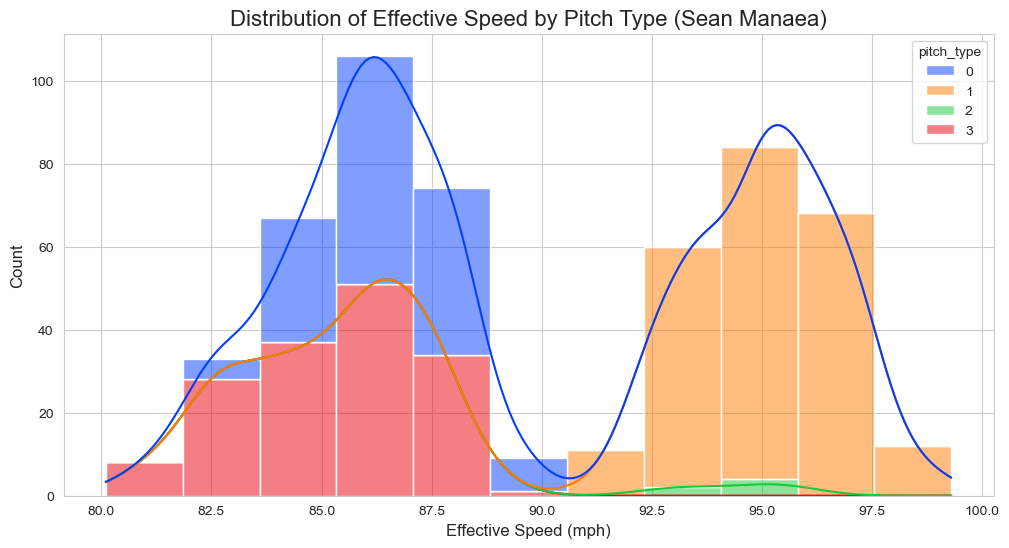

In [27]:

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.histplot(
    data=effective_speed_data, 
    x='effective_speed', 
    hue='pitch_type', 
    kde=True,
    palette='bright', 
    multiple='stack'
)

plt.title('Distribution of Effective Speed by Pitch Type (Sean Manaea)', fontsize=16)
plt.xlabel('Effective Speed (mph)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()


In [28]:
def safe_transform(encoder, value):
    """Safely transforms a value using the encoder.
    If the value is not found in the encoder's classes_, return -1."""
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        return -1

effective_speed_data['stand'] = effective_speed_data['stand'].astype(str)
effective_speed_data['p_throws'] = effective_speed_data['p_throws'].astype(str)
effective_speed_data['if_fielding_alignment'] = effective_speed_data['if_fielding_alignment'].astype(str)
effective_speed_data['of_fielding_alignment'] = effective_speed_data['of_fielding_alignment'].astype(str)
effective_speed_data['pitch_type'] = effective_speed_data['pitch_type'].astype(str)

le_stand = LabelEncoder()
le_p_throws = LabelEncoder()
le_if_align = LabelEncoder()
le_of_align = LabelEncoder()
le_pitch_type = LabelEncoder() 

le_stand.fit(effective_speed_data['stand'])
le_p_throws.fit(effective_speed_data['p_throws'])
le_if_align.fit(effective_speed_data['if_fielding_alignment'])
le_of_align.fit(effective_speed_data['of_fielding_alignment'])
le_pitch_type.fit(effective_speed_data['pitch_type'])

effective_speed_data['stand'] = le_stand.transform(effective_speed_data['stand'])
effective_speed_data['p_throws'] = le_p_throws.transform(effective_speed_data['p_throws'])
effective_speed_data['if_fielding_alignment'] = le_if_align.transform(effective_speed_data['if_fielding_alignment'])
effective_speed_data['of_fielding_alignment'] = le_of_align.transform(effective_speed_data['of_fielding_alignment'])
effective_speed_data['pitch_type'] = le_pitch_type.transform(effective_speed_data['pitch_type'])

X = effective_speed_data.drop(['effective_speed', 'player_name'], axis=1)
y = effective_speed_data['effective_speed']

X = X.apply(pd.to_numeric, errors='coerce')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

speed_model = RandomForestRegressor(n_estimators=100, random_state=42)
speed_model.fit(X_train, y_train)

def predict_effective_speed_by_pitch_type(outs_when_up, inning, balls, strikes, Pitch_number, Bat_score, Fld_score):
    pitch_types = effective_speed_data['pitch_type'].unique() 
    pitch_type_predictions = {} 

    for pitch_type in pitch_types:
        current_game = pd.DataFrame([{
            'pitch_type': pitch_type,
            'stand': safe_transform(le_stand, 'R'),
            'p_throws': safe_transform(le_p_throws, 'L'),
            'balls': balls,
            'strikes': strikes,
            'game_year': 2023,
            'outs_when_up': outs_when_up,
            'inning': inning,
            'pitch_number': Pitch_number,
            'bat_score': Bat_score,
            'fld_score': Fld_score,
            'if_fielding_alignment': safe_transform(le_if_align, 'Standard'),
            'of_fielding_alignment': safe_transform(le_of_align, 'Standard')
        }])

        predicted_speed = speed_model.predict(current_game)[0]
        pitch_type_predictions[le_pitch_type.inverse_transform([pitch_type])[0]] = predicted_speed

    predictions_df = pd.DataFrame(
        pitch_type_predictions.items(), columns=['Pitch Type', 'Predicted Effective Speed']
    ).sort_values(by='Predicted Effective Speed', ascending=False).reset_index(drop=True)

    return predictions_df

outs_when_up = outs_when_up
inning = inning
balls = balls
strikes = strikes
Pitch_number = Pitch_number
Bat_score = Bat_score
Fld_score = Fld_score
predictions_df = predict_effective_speed_by_pitch_type(
    outs_when_up, inning, balls, strikes, Pitch_number, Bat_score, Fld_score
)

predictions_df


/var/folders/bc/69frl30s4xv269mkcmjkv2qr0000gn/T/ipykernel_32450/2981272407.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effective_speed_data['stand'] = effective_speed_data['stand'].astype(str)
/var/folders/bc/69frl30s4xv269mkcmjkv2qr0000gn/T/ipykernel_32450/2981272407.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effective_speed_data['p_throws'] = effective_speed_data['p_throws'].astype(str)
/var/folders/bc/69frl30s4xv269mkcmjkv2qr0000gn/T/ipykernel_32450/2981272407.py:11: SettingWithCopyWar

,Pitch Type,Predicted Effective Speed
0,2,93.718
1,1,93.718
2,0,87.826
3,3,85.410


In [29]:
pitch_type_probs_df

,Pitch Type,Probability
0,CH,0.57
1,SL,0.40
2,FF,0.03
3,SI,0.00


In [30]:
merged_df = pd.merge(pitch_type_probs_df, predictions_df, on='Pitch Type')

In [31]:
merged_df

,Pitch Type,Probability,Predicted Effective Speed


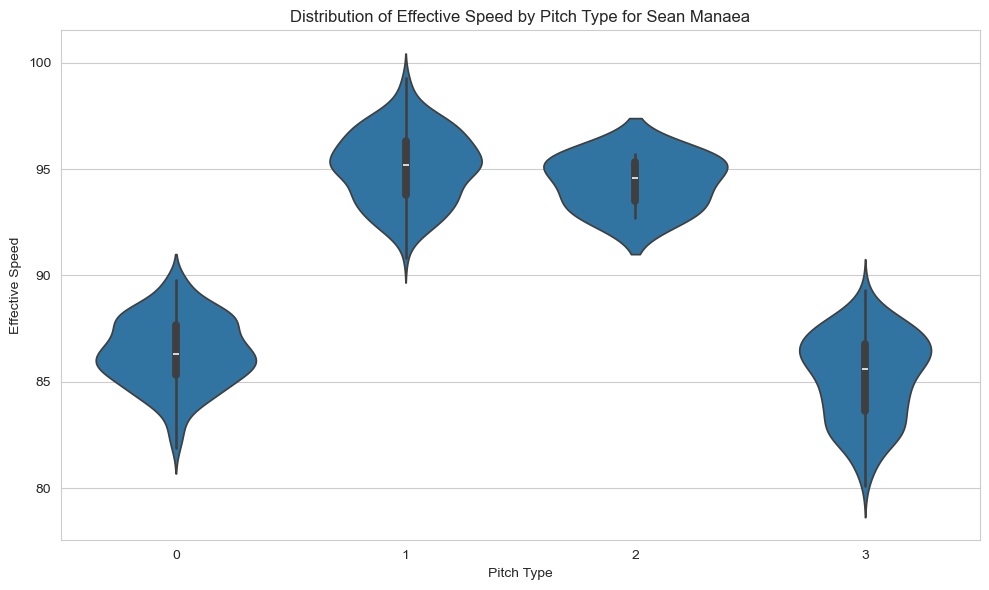

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='pitch_type', y='effective_speed', data=effective_speed_data, inner='box')
plt.title('Distribution of Effective Speed by Pitch Type for Sean Manaea')
plt.xlabel('Pitch Type')
plt.ylabel('Effective Speed')
plt.tight_layout()

plt.show()

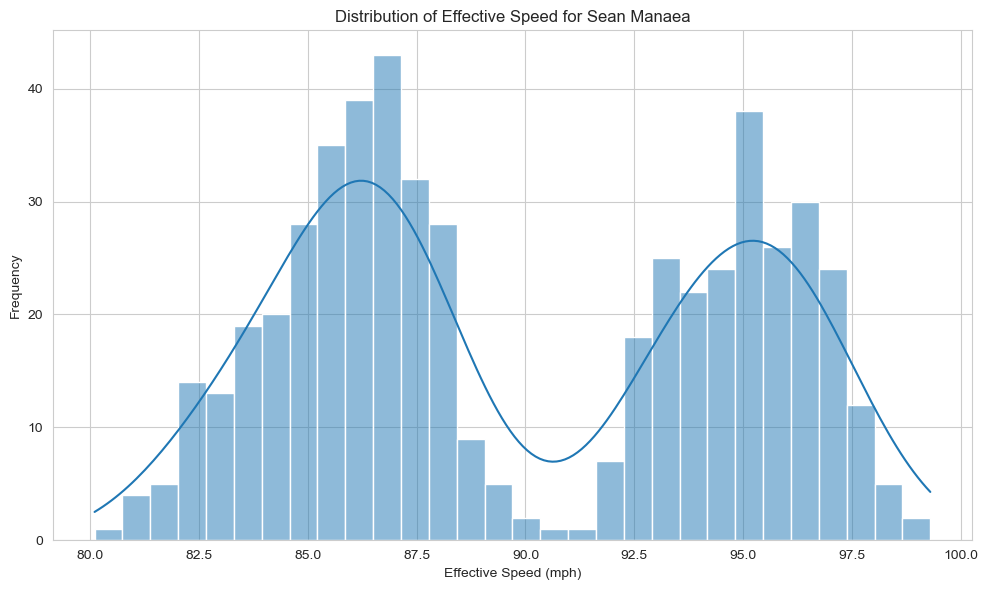

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(effective_speed_data['effective_speed'], kde=True, bins=30)
plt.title('Distribution of Effective Speed for Sean Manaea')
plt.xlabel('Effective Speed (mph)')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()

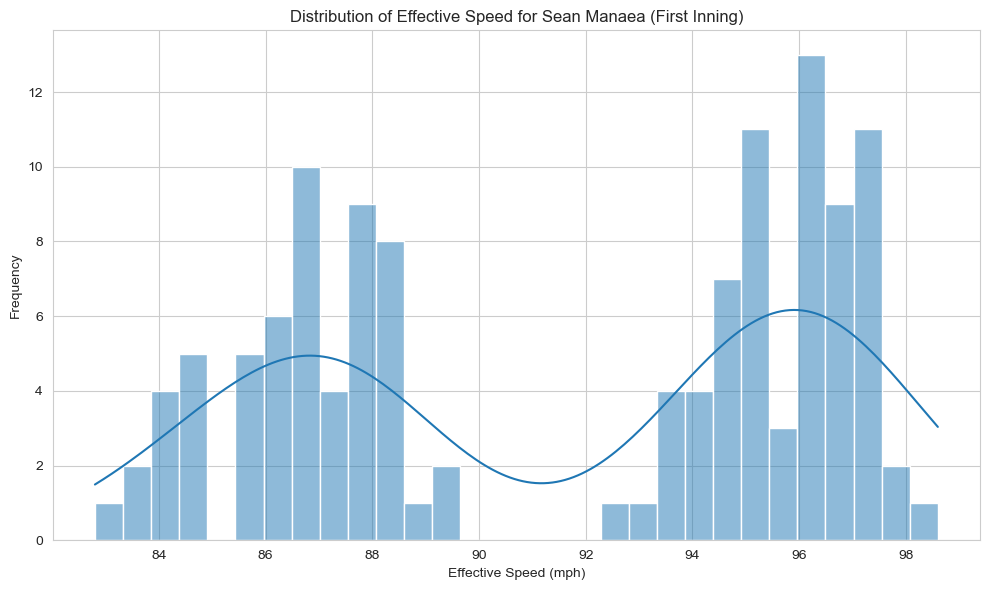

In [34]:
first_inning_data = effective_speed_data[effective_speed_data['inning'] == 1]

plt.figure(figsize=(10, 6))
sns.histplot(first_inning_data['effective_speed'], kde=True, bins=30)
plt.title('Distribution of Effective Speed for Sean Manaea (First Inning)')
plt.xlabel('Effective Speed (mph)')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()